# PID Control Project
The goal of this project is to successfully navigate a car (throttle and steering) around a test track in a simulator. The simulator supplies the cross-track-error (distance from center of lane) and vehicle speed via WebSocket. With controllers implemented in C++ a closed control loop is formed to (de-)accelerate and steer the vehicle.

## Controller
To drive the car around the track 2 PID controllers are used:
- speed controller to maintain a constant speed of the car
- steer controller to keep the car on the track

The main challenge is the steering controller, since it has to work with the deviation from the center as input and convert it to a steering angle. The track also is not straigh and contains various curves, i.e. the controller will have to keep the deviation from the center - cross track error (cte) - at a minimum while the center constantly changes.

## Data import
For debugging and testing a log functionality has been implemented in the C++ porgram. The received and calculated data are written to a .dat file in csv format. The data consists of:
- time: timestamp for each calculation cycle
- speed: current speed as received from simulator
- target_speed: target speed for the PID speed controller
- cte: cross-track-error as received from simulator
- angle: angle as received from simulator
- steer_value: calculated steering angle sent to the simulator

The first plots show the start of the track where the car accelerates to 40 km/h and steers to keep in the center of the lane. It can already be seen that there is a lot of noise in the cte. Further the steering angle is capped at 20°, i.e. the controller becomes non-linear and will be very hard to handle once it hits this regime.

dict_keys(['time', 'speed', 'target_speed', 'cte', 'angle', 'steer_value'])


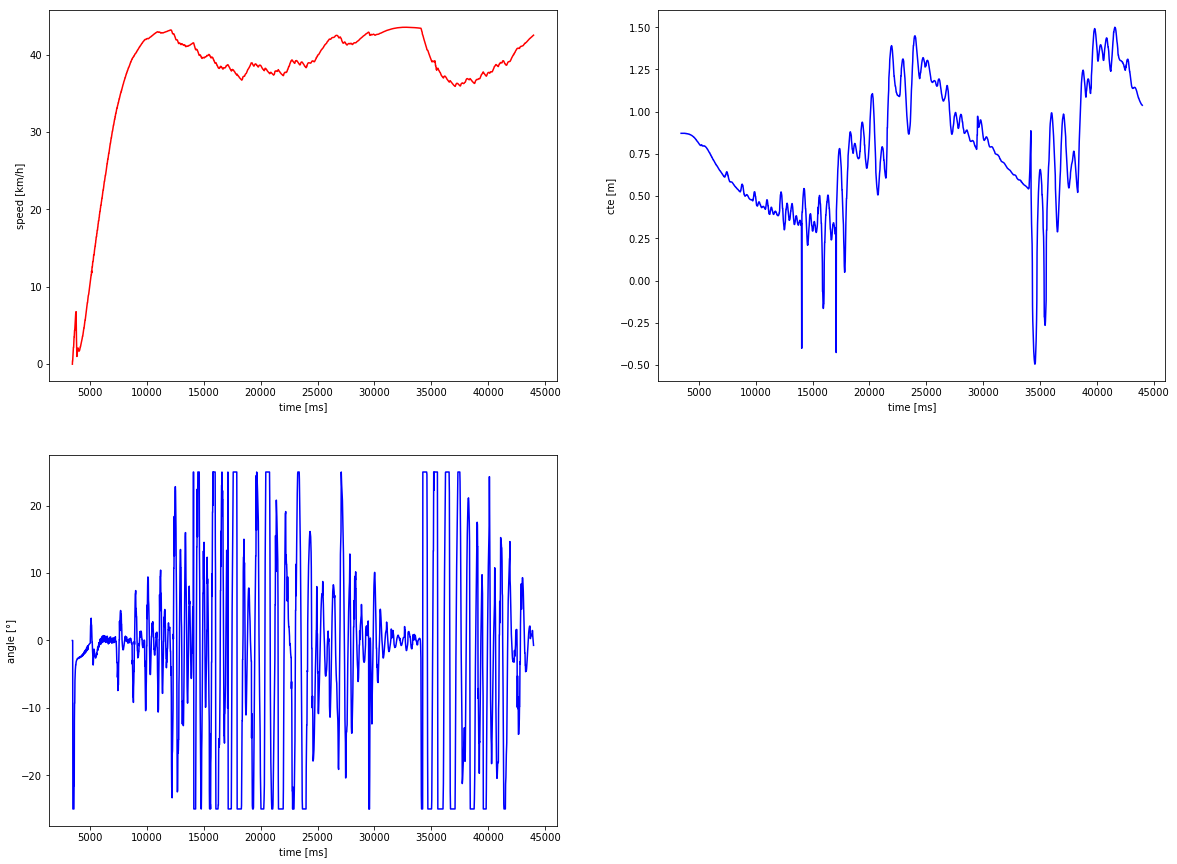

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_csv(file_name, delimiter=','):
    lines = np.genfromtxt(file_name, delimiter='\t', dtype='U')
    data = {key: [] for key in lines[0]}
    for i in range(1,len(lines)):
        for j,value in enumerate(lines[i]):
            data[lines[0][j]].append(float(value))
    return data

data = load_csv(r'./data/test.dat', delimiter='\t')
print(data.keys())

def plot_data(data):
    plt.figure(figsize=(20,15))

    plt.subplot(2,2,1)
    plt.plot(data['time'], data['speed'], 'r')
    plt.ylabel('speed [km/h]')
    plt.xlabel('time [ms]')

    plt.subplot(2,2,2)
    plt.plot(data['time'], data['cte'], 'b')
    plt.ylabel('cte [m]')
    plt.xlabel('time [ms]')

    plt.subplot(2,2,3)
    plt.plot(data['time'], data['angle'], 'b')
    plt.ylabel('angle [°]')
    plt.xlabel('time [ms]')
    
    plt.show()
    
plot_data(data)

## Plant model characterization
To optimize the steering controller, a characterization of the plant model (vehicle simulator) is useful to identify any limitations in the supplied data. For this some trial runs are done by e.g. driving straight ahead and taking a good look at the output data.

### Measurement trial runs
* Drive straight ahead at target speed of 10 (straight.dat)
    * timestamps to get cycle time of callback and ...
    * cte, to get an idea of the input for the steering controller
    * speed to check if PID speed controller works
* Ramp up each cycle by 0.001 (steerramp.dat) and a second with 0.01 (steerramp2.dat)
    * to check the full range for cte and angle parameter

In [4]:
data_straight = load_csv('./data/straight.dat', delimiter='\t')
data_steerramp = load_csv('./data/steerramp.dat', delimiter='\t')
data_steerramp2 = load_csv('./data/steerramp2.dat', delimiter='\t')
print(data_straight.keys())

dict_keys(['time', 'speed', 'target_speed', 'cte', 'angle', 'steer_value'])


### Straight
The measurement data shows that the PID controller for speed works quite well, although some artifacts in the beginning show up. This is probably due to the initialization of the vehicle simulator.

The simulator starts in a slightly left bend curve with the vehicle off-center to the right. By driving straight the inital cte of about 0.8 increases. There seems to be some filtering in the simulator, since it would have been expected to get sharp turns since the track is segmented into straight parts. At the end some artefact shows up, which might be due to a gap between the segments. Artefacts like these will be a problem for the differential part of the controller and will lead to erratic behvaiour. Some addtional filtering of the steering controller output might be necessary.

The timestamps are not very promising. The median is about 24ms, which should be sufficient for adequate controlling. But the standard deviation is quite high (almost 8ms, but thats expected since we work on a non real-time OS). This means that the differential part of the controller will be very unstable. It might help to work with the current timestamp and the corresponding delta-T in the controller. But I will only rely on filtering the output, because due to the other problems it will not be possible to get perfect driving behaviour with a simple PID controller.

Average delta t: 24.116711 (+/-7.899)


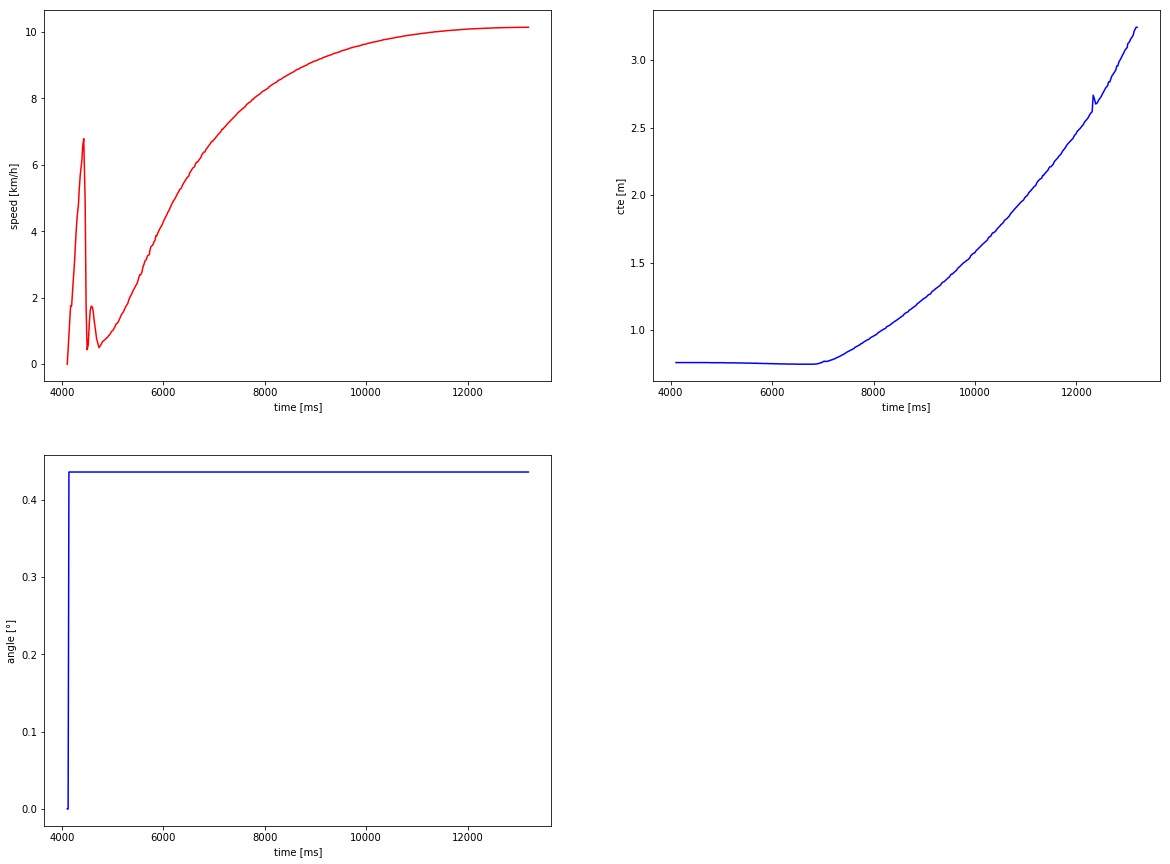

In [8]:
delta_t = np.ediff1d(data_straight['time'])
mean_delta_t = np.mean(delta_t)
std_delta_t = np.std(delta_t)
print('Average delta t: %2f (+/-%.3f)' % (mean_delta_t, std_delta_t))

plot_data(data_straight)

## Constant steering

As next test the vehicle is steered by an increasing ramp. Once with a ramp rate of about 0.5°/s and than with a faster 2.5°/s. This data allows us to observe the dynamic behaviour when actuating the steering parameter. 

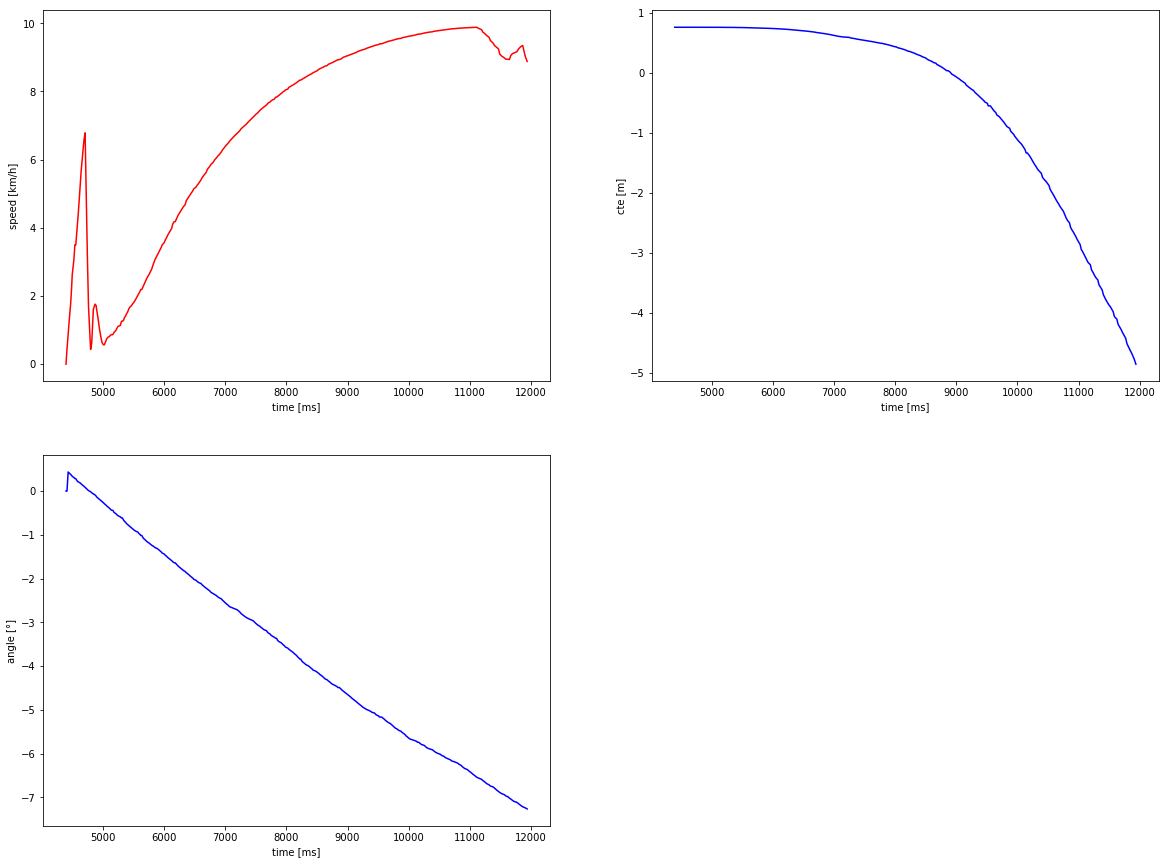

In [9]:
plot_data(data_steerramp)

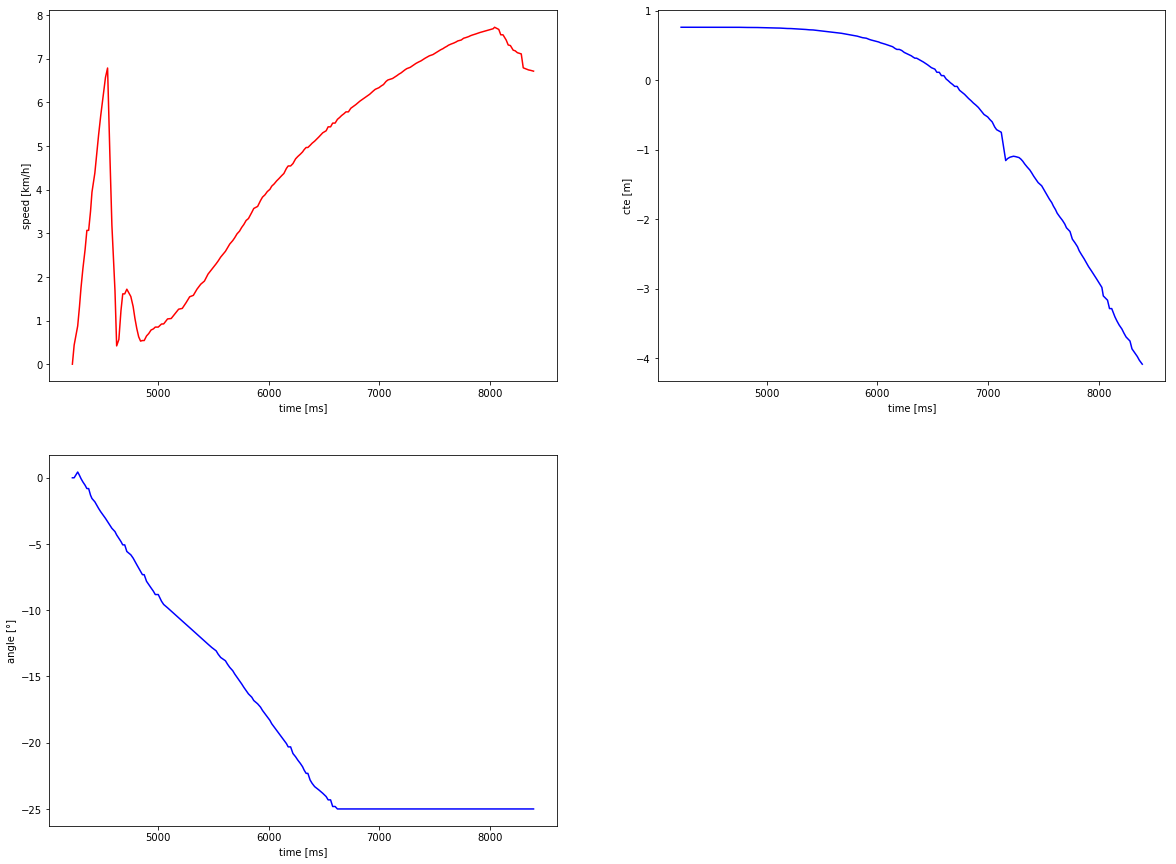

In [10]:
plot_data(data_steerramp2)

## Parameter tuning
Since the time jitter between samples is quite large the set speed was set to 20 km/h to reduce the effect of the jitter noise. The parameters for the speed and steering controller were determined by starting with a pure P controller. Once this worked the D part for better dynamic behaviour and than the I part to reduce the stationary error were introduced.

For the speed controller after some tweaking the following parameters were determined:
* speed K_p = 10
* speed K_i = 0.0001
* speed K_d = 0.01

For the steering controller after some tweaking the following parameters were determined:
* speed K_p = -0.1
* speed K_i = 0
* speed K_d = -4

The I part for the steering controller was set the zero, since the controlled steering system already has an integral behaviour. With this parameters the datalog for a complete circle around the whole track show a maximum cte of about 2[m] in the sharp left and right turns toward the end of the track.

In the video it can also be seen how the controller keeps the car on the track.

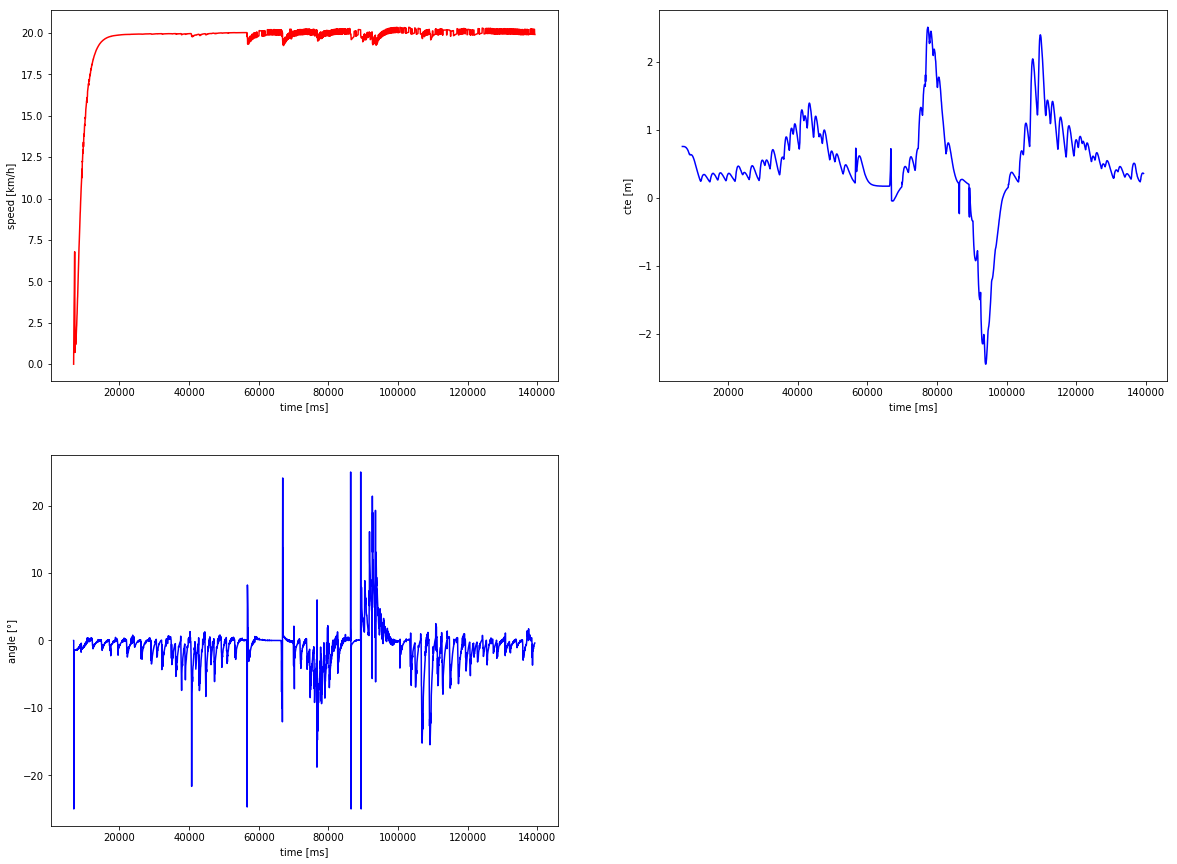

In [11]:
data_full = load_csv('./data/full_circle.dat', delimiter='\t')
plot_data(data_full)

## Further Improvements and Outlook
The speed of the vehicle has an impact of the integral steering behaviour. Therefore, to further improve the steering behaviour and to be able to drive at higher speeds the parameters of the steering controller should be made dependend on the speed.

The curves are not smooth, i.e. the first deviation is non-continous. The PID controller has a hard time reacting to this sudden changes of the cte. Some smoothing with PT1 filters may improve the performance of the controller.